In [10]:
import Nio
import numpy as np
import matplotlib.pyplot as plt

########import test说明####
#使用f2py命令："f2py -m test -c mixData.f90"，将mixData.f90文件编译为名为"test"的动态链接库，再在python中import该test库
#f2py为一种在python使用fortran代码的方法，详情参考：https://numpy.org/doc/stable/f2py/
import test
###########################

#########设置中文显示########
plt.rcParams['font.family']='Heiti TC'
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [11]:
#读取原始排放源清单NOx的排放量
f_oData=Nio.open_file('./NOx.nc',mode='r',format='nc')
oData=f_oData.variables['rdt'][:][74:86,134:150]#原始排放数据为全国区域，此处索引值为选取四川盆地区域
oX=f_oData.variables['lon'][:][74:86,134:150]
oY=f_oData.variables['lat'][:][74:86,134:150]
f_oData.close()

#读取虚拟的四川盆地人口密度数据（由随机函数生成）
f_rData=Nio.open_file('./virtual_population_data_sichuan_basin.nc',mode='r',format='nc')
rData=f_rData.variables['population'][:]
rX=f_rData.variables['lon'][:]
rY=f_rData.variables['lat'][:]
f_rData.close()

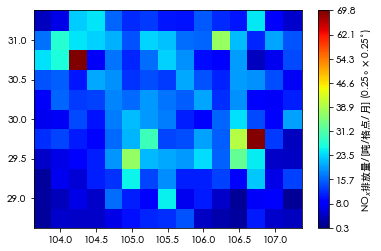

In [12]:
#展示NOx排放量数据：
o_emis=plt.pcolormesh(oX,oY,oData,vmin=oData.min(),vmax=oData.max(),cmap='jet')#两高值区为：成都（左上），重庆（右下）
cbar=plt.colorbar(o_emis,ticks=np.linspace(oData.min(),oData.max(),10),format='%2.1f')
cbar.set_label('NO$_{x}$排放量/[吨/格点/月] (0.25${\circ} \\times $0.25$^{\circ}$)')

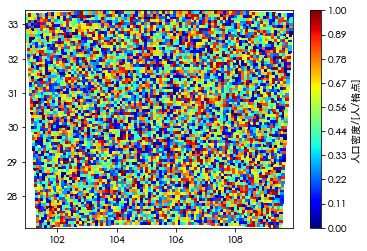

In [13]:
#展示虚拟人口密度数据（人口数据由随机函数生成）：
popu=plt.pcolormesh(rX,rY,rData,vmin=rData.min(),vmax=rData.max(),cmap='jet')
cbar=plt.colorbar(popu,ticks=np.linspace(rData.min(),rData.max(),10),format='%2.2f')
cbar.set_label('人口密度/[人/格点]')

In [14]:
#调用fortran写的"mix_data"subroutine
#mix_data的参数列表为：
#oData：原始排放量数据；rData：其他数据（如此处的人口数据）；oX：原始排放量数据对应经度坐标；oY：原始排放量数据对应纬度坐标；
#rX：其他数据对应经度坐标；rY：其他数据对应纬度坐标；0.25：原始数据经向分辨率（根据原始数据情况进行调整）；0.25：原始数据纬向分辨率（根据原始数据情况进行调整）。
output=test.mix_data(oData,rData,oX,oY,rX,rY,0.25,0.25)
#test.mix_data()的输出结果为一个10元素元组，赋值给output，output最后一个元素即为数据融合后的结果

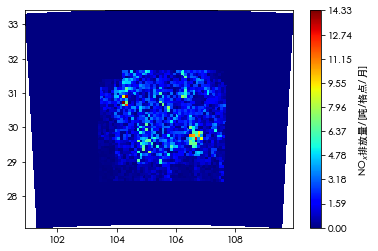

In [15]:
#因此，展示output[9]，即融合后的结果为：
mixed=plt.pcolormesh(rX,rY,output[9],vmin=output[9].min(),vmax=output[9].max(),cmap='jet')
cbar=plt.colorbar(mixed,ticks=np.linspace(output[9].min(),output[9].max(),10),format='%2.2f')
cbar.set_label('NO$_{x}$排放量/[吨/格点/月]')

In [16]:
#验证：
output[9].sum() #处理后区域排放总和

2686.3232

In [17]:
oData.sum() #原始清单区域排放总和#说明处理前后排放量守恒，原始清单分辨率得以提升。

2686.3232

In [18]:
#总结：